# Demographic Impact on Mental Health Conditions

## INTRODUCTION

Goal: to analyze how different demographic groups (e.g., age, gender, country) experience and report mental health conditions such as depression and anxiety in the technology industry. This includes exploring prevalence, potential risk factors, and how workplace environments influence mental well-being.

Are certain age groups more likely to report anxiety or depression?

Do responses differ significantly between men and women?

Is there a regional or national variation in responses?


This can provide insights into which groups might need targeted mental health interventions.

Importing libraries :

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import statsmodels.stats.proportion as smp


from MentalHealthCustomFunctionsDictionaries import (
    filter_unrealistic_ages,
    question_mapping,
    gender_mapping,
    country_mapping,
    condition_mapping,
    plot_age_boxplot,
    plot_geographic_distribution,
    plot_state_distribution,
    get_state_data,
    plot_age_distribution,
    plot_gender_distribution,
    countries_distribution_percentages,
    plot_cleaned_state_distribution_horizontal_bar_chart,
    plot_mental_health_conditions_with_CI,
    categorize_condition,
    generate_age_conditions_contingency_heatmap,
    rank_top_conditions_sql,
    rank_top_20_categorized_conditions,
    rank_top_20_conditions_by_state,
    plot_answers_by_year,
    unique_questions_per_year,
    plot_unique_respondents_by_year,
    count_unique_genders_2016,
    count_men_conditions_2016,
    count_women_conditions_2016,
    count_other_gender_conditions_2016,
    plot_multibar_conditions_2016,
    plot_multibar_conditions_percentage_2016,
)

Defining the database :

In [2]:
db_path = "mental_health.sqlite"

Establishing a connection to a SQLite database and creating a cursor object to interact with it. The cursor is like a handle that you use to execute SQL queries and fetch results from the database :

In [3]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

Using a context manager to automatically close the connection. When the code block within the with statement will be exited, the connection will be automatically closed, even if the errors occur :

In [4]:
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()

## DATA CLEANING

Fetching all table names :

In [5]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
table_names = [table[0] for table in tables]
print("Tables in database:", table_names)

Tables in database: ['Answer', 'Question', 'Survey']


Previewing each table's schema (PRAGMA table_info (table_name) - retrieves metadata about a table, including information about its columns) :

In [6]:
for table in table_names:
    print(f"\nSchema of {table}:")
    cursor.execute(f"PRAGMA table_info({table});")
    schema = cursor.fetchall()
    for column in schema:
        print(column)


Schema of Answer:
(0, 'AnswerText', 'VARCHAR(10000)', 0, None, 0)
(1, 'SurveyID', 'INTEGER', 0, None, 0)
(2, 'UserID', 'INTEGER', 0, None, 0)
(3, 'QuestionID', 'INTEGER', 0, None, 0)

Schema of Question:
(0, 'questiontext', 'VARCHAR(1000)', 0, None, 0)
(1, 'questionid', 'INTEGER', 0, None, 0)

Schema of Survey:
(0, 'SurveyID', 'INTEGER', 1, None, 1)
(1, 'Description', 'VARCHAR(255)', 0, None, 0)


Reading the data from three different tables in a SQLite database and loading them into the pandas :

In [7]:
answer_df = pd.read_sql("SELECT * FROM Answer", conn)
question_df = pd.read_sql("SELECT * FROM Question", conn)
survey_df = pd.read_sql("SELECT * FROM Survey", conn)

Merging tables to create a full dataset. This combines related data, makes it easier to analyze and understand it :

In [8]:
merged_df = answer_df.merge(
    question_df, left_on="QuestionID", right_on="questionid", how="left"
).merge(survey_df, on="SurveyID", how="left")

Standardizing and grouping similar questions across survey years. This is a crucial step in data cleaning and preparation, especially when dealing with survey data where questions might be phrased differently but essentially ask the same thing. It also gives more data consistency and code readibility (using dictionary from a supportive file) :

In [9]:
merged_df["questiontext"] = merged_df["questiontext"].replace(question_mapping)

Dealing with missing data. Filling any missing values (NaN) in the AnswerText column of merged_df with the string "Not Provided" :

In [10]:
merged_df["AnswerText"] = merged_df["AnswerText"].fillna("Not Provided")

Converting age to numeric. This is a crucial step to ensure performing numerical operations on the age data.:

In [11]:
merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"] = pd.to_numeric(
    merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"], errors="coerce"
)

Taking a closer look at the age outliers with box plot (function from a supportive file): 

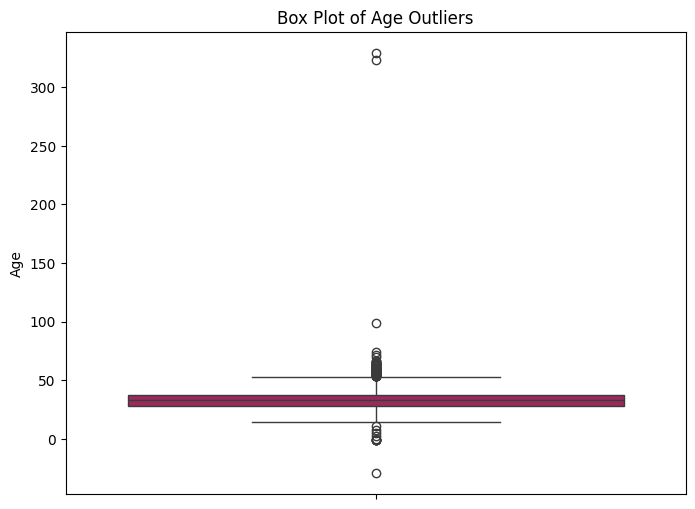

In [12]:
plot_age_boxplot(merged_df)

It seems that there's some unrealistic ages like the one's above 100 and below 0 we should remove them.

Converting 'AnswerText' related to age to a numeric (Without errors="coerce", pd.to_numeric() would raise a ValueError). The code snippet extracts the "AnswerText" values related to "Age", attempts to convert them to numbers, and replaces any non-convertible values with NaN.  The result is stored in temp_age_numeric :

In [13]:
temp_age_numeric = pd.to_numeric(
    merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"], errors="coerce"
)

Detecting and replacing outliers, ensuring negative ages and unrealistically old ages are handled. Using function filter_unrealistic_ages that filters out unlikely age values from a Pandas Series, replacing them with NaN :

In [14]:
temp_age_numeric_cleaned = filter_unrealistic_ages(
    temp_age_numeric, min_age=0, max_age=100
)
merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"] = (
    temp_age_numeric_cleaned.fillna("Not Provided")
)

Isolating the age data, removing missing values :

In [15]:
age_series = merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"].dropna()

Age data processing and categorization :
1. Converts the age_series to numeric (errors="coerce" forces any non-numeric values to become NaN). Removes any NaN values that might have resulted from the previous conversion, ensuring only numbers should be staying.
2. Creating "Age group" column in the age_series after all cleaning and processing. Two lists with labels and bins are created as well. Bins defines age ranges groups.
3. Checking unique values.

In [16]:
age_series = pd.to_numeric(age_series, errors="coerce").dropna()

if not age_series.empty:
    merged_df.loc[merged_df["questiontext"] == "Age", "Age Group"] = pd.cut(
        age_series,
        bins=[0, 19, 29, 39, 49, 59, 100],
        labels=["<20", "20-29", "30-39", "40-49", "50-59", "60+"],
        right=False,
    )
else:
    merged_df.loc[merged_df["questiontext"] == "Age", "Age Group"] = "Not Provided"

print(age_series.unique())

[37. 44. 32. 31. 33. 35. 39. 42. 23. 29. 36. 27. 46. 41. 34. 30. 40. 38.
 50. 24. 18. 28. 26. 22. 19. 25. 45. 21. 43. 56. 60. 54. 55. 48. 20. 57.
 58. 47. 62. 51. 65. 49.  5. 53. 61.  8. 11. 72. 52. 17. 63. 99.  3. 66.
 59. 15. 74. 70. 64. 67.  0.]


Checking the situation with genders :

In [17]:
raw_genders = merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"]
print("Raw Unique Genders Before Mapping:", raw_genders.unique())

Raw Unique Genders Before Mapping: ['Female' 'Male' 'Male-ish' 'Trans-female' 'something kinda male?'
 'queer/she/they' 'non-binary' 'Nah' 'All' 'Enby' 'fluid' 'Genderqueer'
 'Androgyne' 'Agender' 'Guy (-ish) ^_^' 'male leaning androgynous'
 'Trans woman' 'Neuter' 'Female (trans)' 'queer' 'A little about you' 'p'
 'ostensibly male, unsure what that really means' 'Bigender'
 'Female assigned at birth' 'fm' 'Transitioned, M2F'
 'Genderfluid (born female)' 'Other/Transfeminine'
 'Female or Multi-Gender Femme' 'Androgynous' 'male 9:1 female, roughly'
 '-1' 'Other' 'nb masculine' 'none of your business' 'genderqueer' 'Human'
 'Genderfluid' 'genderqueer woman' 'mtf' 'Queer' 'Fluid'
 'Male/genderqueer' 'Nonbinary' 'human' 'Unicorn' 'Male (trans, FtM)'
 'Genderflux demi-girl' 'female-bodied; no feelings about gender' 'AFAB'
 'Transgender woman' 'male' 'female' 'male/androgynous'
 'uhhhhhhhhh fem genderqueer?' 'God King of the Valajar' 'Non-binary'
 'Agender/genderfluid' 'sometimes' 'Woman-iden

Gender mapping, standardizing gender responses. Code addresses potential inconsistencies in how people might input their gender, ensuring uniformity for analysis (using dictionary from a supportive file) :

In [18]:
if "Gender" in merged_df["questiontext"].values:

    merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"] = (
        merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"]
        .astype(str)
        .str.strip()
        .str.title()
        .replace(gender_mapping)
    )

    merged_df = merged_df[
        (merged_df["questiontext"] != "-1") & (merged_df["AnswerText"] != "-1")
    ]

    valid_genders = ["Male", "Female", "Other"]
    merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"] = merged_df.loc[
        merged_df["questiontext"] == "Gender", "AnswerText"
    ].apply(lambda x: x if x in valid_genders else "Other")

print(
    "Unique Genders after fixing:",
    merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"].unique(),
)

Unique Genders after fixing: ['Female' 'Male' 'Other']


Standardizing country names for better data consistency. As well there's countries with the same name like United States and United States of America, we have to take care of that using country_mapping dictionary and replace function :


In [19]:
merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"] = (
    merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"]
    .str.strip()
    .str.title()
)

merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"] = merged_df.loc[
    merged_df["questiontext"] == "Country", "AnswerText"
].replace(country_mapping)

 Printing cleaned dataset :

The data on states are not clean, I will have to custom get_state_data function to properly manage it : 

In [20]:
state_data = get_state_data(db_path)

print(state_data.head())

        state  respondent_count
0  California               382
1    Illinois               223
2  Washington               168
3    New York               146
4   Tennessee               121


## General overview of the survey and timeline

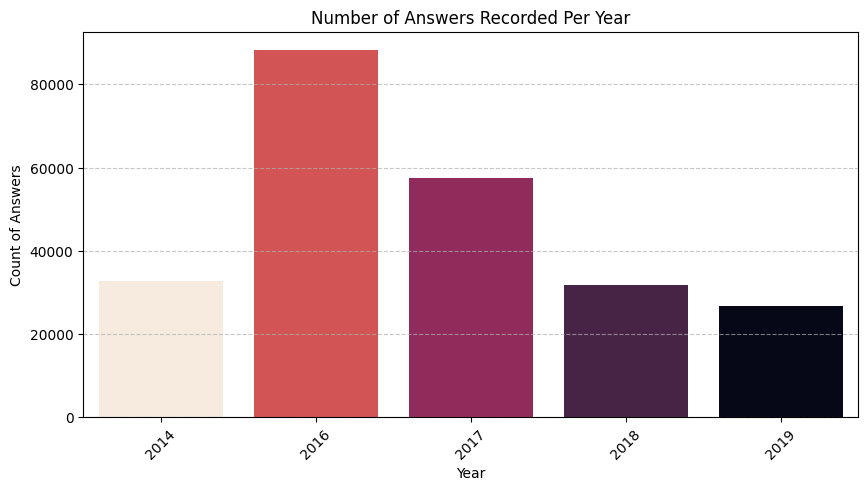

,Year,AnswerCount
0,2014,32760
1,2016,88238
2,2017,57456
3,2018,31692
4,2019,26752


In [21]:
(plot_answers_by_year)(db_path)

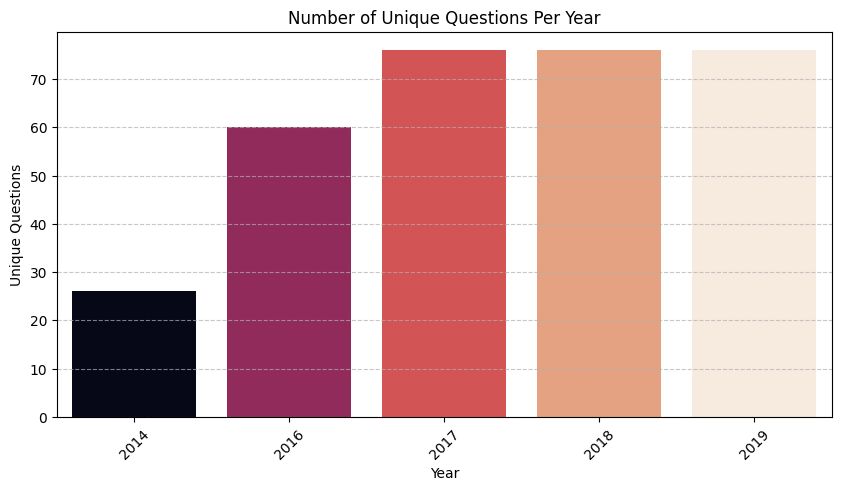

,Year,UniqueQuestions
0,2014,26
1,2016,60
2,2017,76
3,2018,76
4,2019,76


In [22]:
unique_questions_per_year(db_path)

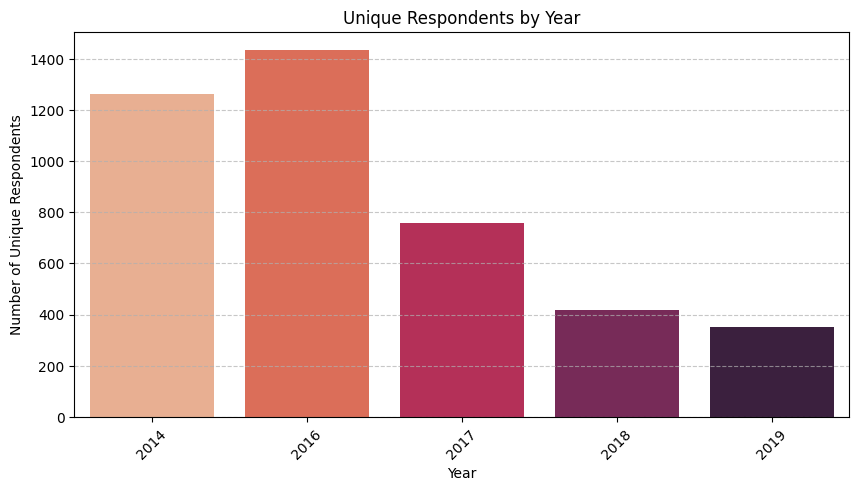

In [23]:
unique_users_by_year_df = plot_unique_respondents_by_year(db_path)

"If yes, what condition(s) have you been diagnosed with?" - If you mental condition, what conditions(s) have you been diagnosed?

In [24]:
sql_query = """
SELECT QuestionText
FROM Question
WHERE QuestionID = 115;
"""

with sqlite3.connect(db_path) as conn:
    question_115_text = pd.read_sql_query(sql_query, conn)

# Display the text of Question ID 115
question_115_text

,questiontext
0,"If yes, what condition(s) have you been diagno..."


In [25]:
sql_query = """
SELECT DISTINCT SUBSTR(SurveyID, 1, 4) AS Year
FROM Answer
WHERE QuestionID = 115
ORDER BY Year;
"""

with sqlite3.connect(db_path) as conn:
    question_115_years = pd.read_sql_query(sql_query, conn)
    print(question_115_years)

   Year
0  2016


In [26]:
sql_query = """
SELECT DISTINCT QuestionID, QuestionText
FROM Question
WHERE LOWER(QuestionText) LIKE '%condition%' OR LOWER(QuestionText) LIKE '%mental health%' 
   OR LOWER(QuestionText) LIKE '%diagnosed%' OR LOWER(QuestionText) LIKE '%disorder%'
ORDER BY QuestionID;
"""

with sqlite3.connect(db_path) as conn:
    similar_questions = pd.read_sql_query(sql_query, conn)
    print(similar_questions)

    questionid                                       questiontext
0            7  Have you ever sought treatment for a mental he...
1           10  Does your employer provide mental health benef...
2           11  Is your anonymity protected if you choose to t...
3           12  Would you bring up a mental health issue with ...
4           14  Do you know the options for mental health care...
..         ...                                                ...
71         112  Did you hear of or observe negative consequenc...
72         113  Do you feel that being identified as a person ...
73         114  Do you think that team members/co-workers woul...
74         115  If yes, what condition(s) have you been diagno...
75         116  If maybe, what condition(s) do you believe you...

[76 rows x 2 columns]


## Overview on Main Mental Conditions and Their Prevelance

Understanding the prevalence of diagnosed mental health conditions helps identify the most common disorders among respondents. This analysis focuses on self-reported mental health diagnoses based on Question 115, where participants specify their diagnosed conditions.

The bar chart below shows the prevalence of diagnosed mental health conditions, categorized into major disorder types:

Anxiety Disorders - Includes Generalized Anxiety, Social Anxiety, Phobias

Depression - Includes Mood Disorders & Clinical Depression

OCD (Obsessive-Compulsive Disorder)

PTSD (Post-Traumatic Stress Disorder)

Eating Disorders - Includes Anorexia & Bulimia

Stress Disorders - Includes Stress Response Syndromes

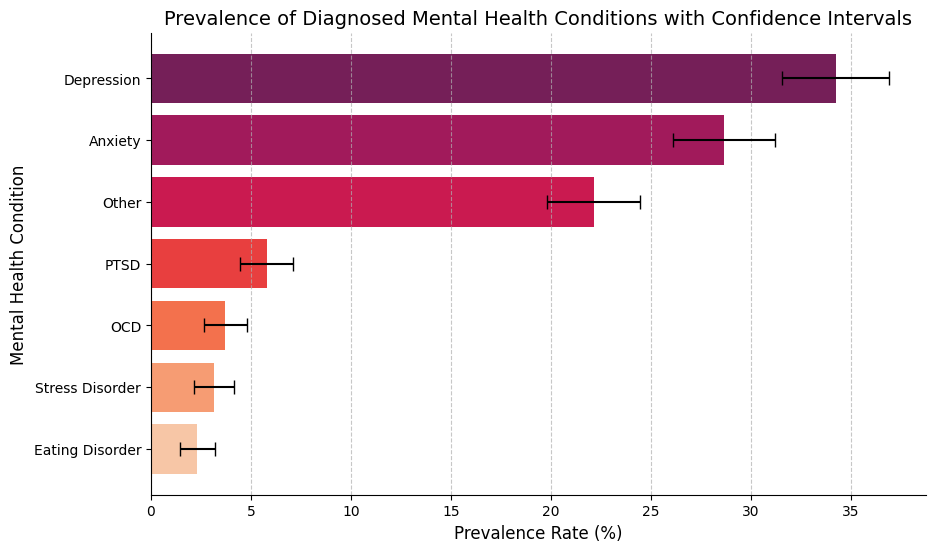

In [27]:
mental_health_summary_CI_df = plot_mental_health_conditions_with_CI(
    db_path=db_path,
    condition_mapping=condition_mapping,
)

Key Findings :

Conditions like Anxiety and Depression are the most frequently reported mental health disorders.

OCD, PTSD, and Eating Disorders are also reported but at a lower frequency.

Some responses were unstructured or unclear and categorized under "Other" conditions.

The most frequently reported mental health condition among respondents is Depression, followed by Anxiety Disorders and PTSD.

Depression has the highest prevalence, suggesting that mood disorders are a major concern among respondents.

Confidence intervals (error bars) indicate the uncertainty in prevalence estimates. Wider intervals suggest greater variability in responses, while narrower intervals indicate more certainty.

Bipolar Disorder, OCD, and Eating Disorders have lower prevalence but remain critical areas of concern.

Confidence intervals provide an estimate of the true prevalence within the broader population.

If a condition has a wide confidence interval, it suggests higher uncertainty in the estimated rate, possibly due to fewer responses or varying reporting patterns.

If a confidence interval is narrow, it indicates more reliable data with a higher degree of certainty.

##  Demographic Distribution    

Visualizing results with a bar chart :

The bar chart categorizes respondents into six age groups:

<20 (Younger respondents)
20-29 (Early-career professionals or students)
30-39 (Mid-career professionals)
40-49 (Experienced professionals)
50-59 (Late-career professionals)
60+ (Retired or senior professionals)

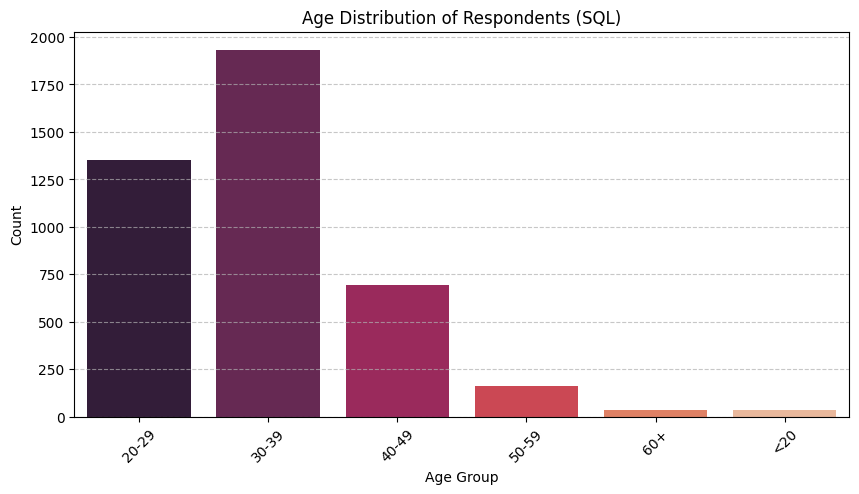

In [28]:
plot_age_distribution(db_path)

The 20-29 age group has the highest participation, likely representing early-career professionals and students who are more engaged in digital platforms and surveys.
The 30-39 age group also shows strong participation, reflecting mid-career individuals who may have a vested interest in workplace or mental health discussions.
Respondents above 50 years old are significantly fewer, which could indicate lower survey reach among older demographics or less willingness to participate.

This distribution suggests that younger individuals, particularly those in their 20s and 30s, are more engaged with the survey topic. If the survey relates to workplace culture, mental health, or technology, this age skew could reflect the greater awareness and discussions around these issues among younger professionals.

Visualizing the data :

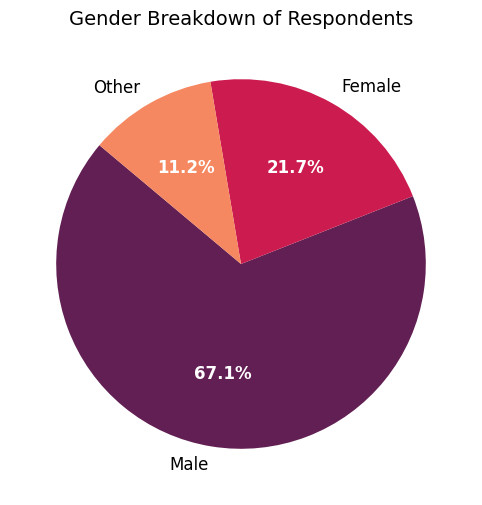

In [29]:
plot_gender_distribution(db_path)

67.1% of respondents are male, with females (21.7%) and other gender identities (11.2%) being clear minorities. This aligns with broader industry trends, where men dominate tech-related fields. Factors such as workplace culture, hiring biases, and gender disparities in STEM education may contribute to this imbalance.

What is the geographic distribution of respondents?

The geographic distribution of survey respondents provides a view of regional engagement, but it may also reflect external factors influencing participation.

Key Considerations:

Tech Industry Presence: Higher response rates in certain regions may correlate with tech sector development rather than overall engagement. Areas with a strong technology workforce likely have higher survey visibility.

Survey Outreach Bias: Some regions may show higher participation due to targeted outreach efforts. If the survey was shared more actively in specific countries or states, the data might reflect where respondents were most likely to be reached rather than genuine interest differences.

Language & Accessibility: Lower participation in some regions could be due to language barriers or lack of familiarity with the survey platform, affecting overall representation.

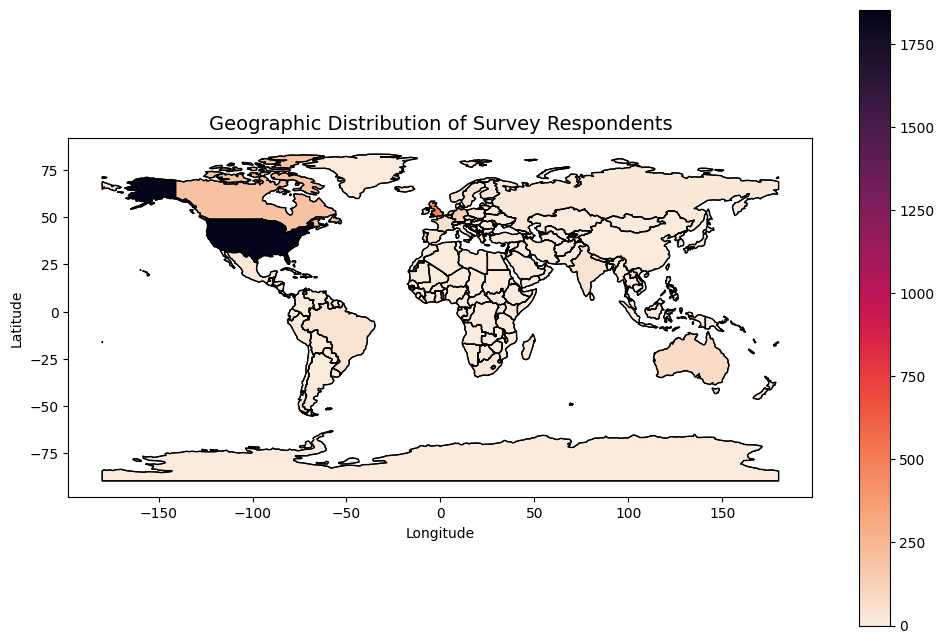

In [30]:
shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"

plot_geographic_distribution(db_path, shapefile_path)

World map graph shows that the survey participants were mainly from US, with small of participants being from UK, Germany, Australia and Canada as well.

In [31]:
# Get cleaned country distribution from SQL
cleaned_country_df = countries_distribution_percentages(db_path)

# Display cleaned country data
print(cleaned_country_df)

           Country  Percentage
0    United States   61.735420
1   United Kingdom   11.427217
2           Canada    4.717876
3          Germany    3.224277
4      Netherlands    2.323376
..             ...         ...
75        Ethiopia    0.023708
76         Ecuador    0.023708
77          Brunei    0.023708
78         Belarus    0.023708
79    Bahamas, The    0.023708

[80 rows x 2 columns]


United States (61.73%) - The overwhelming majority of responses came from the U.S., likely due to survey reach, language accessibility, and industry concentration.

United Kingdom (11.43%) - A significant number of responses suggest strong awareness or outreach efforts in English-speaking countries.

Canada (4.72%) & Germany (3.22%) - These countries show moderate participation, possibly reflecting their tech industry engagement.

Low-Participation Countries (≤0.02%) - Countries like Ethiopia, Ecuador, Brunei, Belarus, and The Bahamas have minimal engagement, possibly due to limited survey outreach or tech sector presence in these regions.

Let's take a closer look at US and it's states geographic distribution of survey respondents :

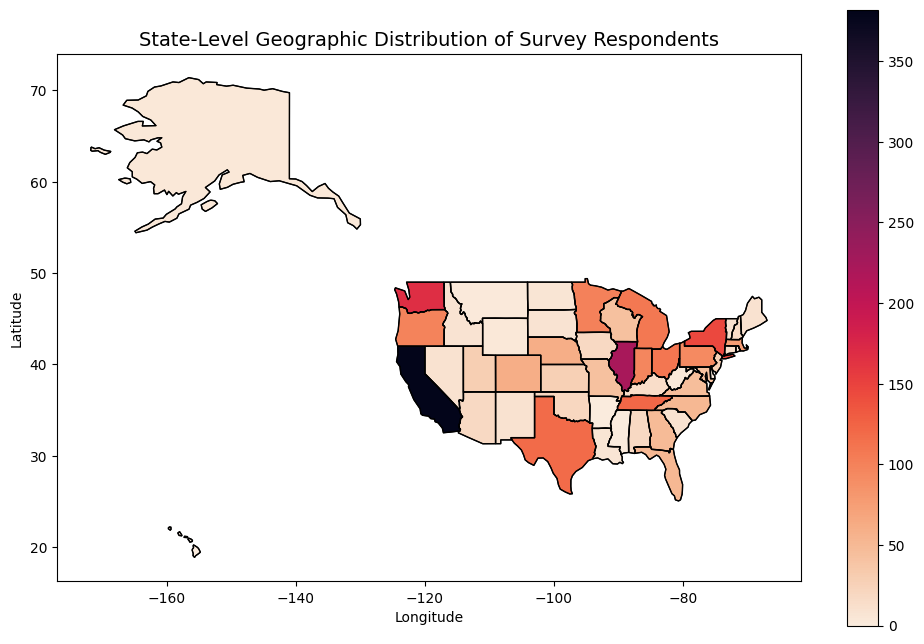

In [32]:
shapefile_path = "ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"

plot_state_distribution(db_path, shapefile_path)

State map is dominated by California, followed by Ilinious and Washington states. Not surprising since majority of technology companies are based in California.

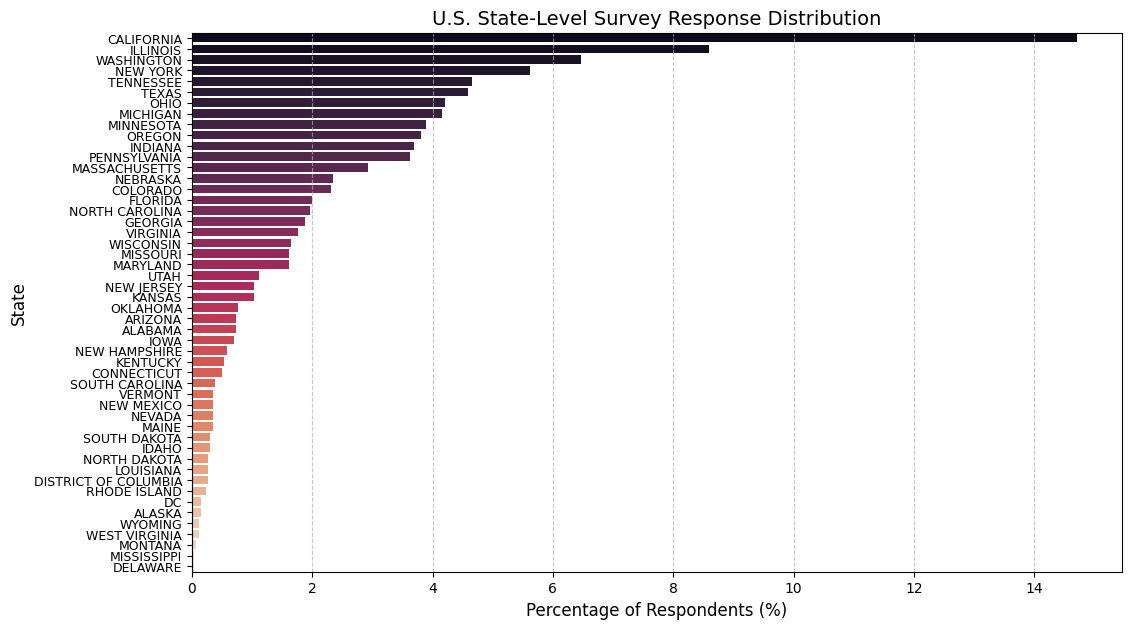

In [33]:
cleaned_state_df = plot_cleaned_state_distribution_horizontal_bar_chart(db_path)

Key findings :

•California leads the responses, with the highest percentage of survey participants. This aligns with its position as a major tech and corporate hub, where workplace mental health discussions are more prevalent.

•Illinois, Washington, and New York also show strong participation, reflecting high concentrations of professionals in urban areas and industries where mental health awareness is growing.

•Texas and Florida, despite having large populations, show relatively lower response rates, suggesting possible regional differences in survey outreach or awareness.

•Lower participation states (e.g., Montana, Mississippi, Delaware) make up a very small percentage of responses, likely due to lower survey visibility in these regions or differences in workplace culture.

Additional insights :

1. Higher participation in states with strong tech, finance, and corporate presence suggests that workplace mental health awareness may be more developed in these regions.

2. Lower engagement in some states could indicate gaps in awareness, industry representation, or outreach strategies.

3. Future surveys should consider targeted outreach in lower-participation states to improve geographic representation.

In [34]:
rank_top_20_categorized_conditions(db_path)

                     country         category  total_count  rank
0   United States of America       Depression       347760     1
1   United States of America          Anxiety       289800     2
2   United States of America            Other       224280     3
3             United Kingdom       Depression        74520     4
4             United Kingdom          Anxiety        62100     5
5   United States of America             PTSD        58800     6
6             United Kingdom            Other        48060     7
7   United States of America              OCD        37800     8
8                     Canada       Depression        32292     9
9   United States of America  Stress Disorder        31920    10
10                    Canada          Anxiety        26910    11
11                   Germany       Depression        24012    12
12  United States of America  Eating Disorder        23520    13
13                    Canada            Other        20826    14
14                   Germ

We can assume that in all countries the most popular mental conditions among respondants is Depression, so general results are not biased only towards USA. Following  Depression, second is Anxiety, which confirms global pattern and that location doesn't do too much impact on mental conditions variety.

In [35]:
result_df = rank_top_20_conditions_by_state(db_path)

print(result_df)

           state    Category  count
0     California  Depression  53560
1     California     Anxiety  44850
2       Illinois  Depression  23072
3       Michigan  Depression  19776
4       Illinois     Anxiety  19320
5       New York  Depression  18540
6          Texas  Depression  17716
7     Washington  Depression  17716
8      Minnesota  Depression  17304
9       Michigan     Anxiety  16560
10    California       Other  15730
11      New York     Anxiety  15525
12        Oregon  Depression  15244
13         Texas     Anxiety  14835
14    Washington     Anxiety  14835
15     Minnesota     Anxiety  14490
16  Pennsylvania  Depression  13596
17        Oregon     Anxiety  12765
18      Colorado  Depression  11536
19  Pennsylvania     Anxiety  11385


Looking closer at US state situation we can see same trends as in global list. In majority of states Depression is the most often condition, followed by Anxiety problems close by. We can be sure now that location does not impact mental conditions in technology sector workplaces.

## Relationship between mental conditions and age

Frequency distribution of categorical variables (age groups and mental health conditions) :

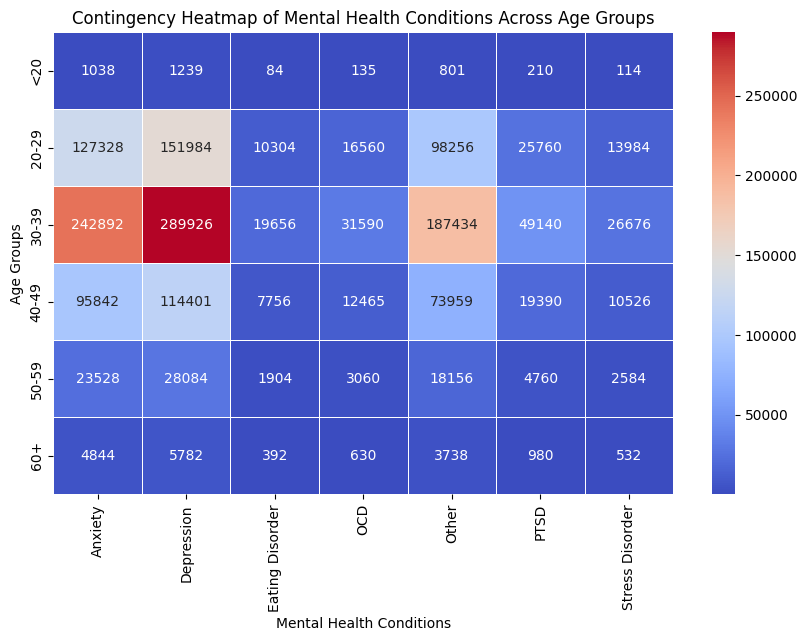

In [36]:
contingency_table = generate_age_conditions_contingency_heatmap(db_path, merged_df)



Key Observations

- Younger respondents (<20, 20-29, 30-39) have the highest reported cases of mental health conditions.

- Anxiety and Depression are the most common conditions** across all age groups.

- PTSD and Eating Disorders are more frequent in younger age groups.

- Older age groups (50-59, 60+) report significantly fewer cases across all conditions.


Insights

1. Depression and Anxiety show the highest prevalence across all age groups**, peaking in the 30-39 range.
2. OCD and Eating Disorders appear more frequently in younger age groups**, with numbers declining in older groups.
3. PTSD is notable in the younger demographics but drops significantly in older adults.
4. The "Other" category is consistently high**, suggesting a range of less common but significant conditions.



## Deeper Analysis of Mental Conditions and Genders

In [37]:
gender_counts_2016 = count_unique_genders_2016(db_path)

print(gender_counts_2016)

{'Male': np.int64(1057), 'Female': np.int64(336), 'Other': np.int64(13)}


In [ ]:
men_conditions_2016 = count_men_conditions_2016(db_path, condition_mapping)
print("Men Conditions in 2016:", men_conditions_2016)

Men Conditions in 2016: {'Anxiety': 214, 'Depression': 243, 'OCD': 28, 'PTSD': 36, 'Eating Disorder': 10, 'Stress Disorder': 27, 'Other': 138}


In [ ]:
women_conditions_2016 = count_women_conditions_2016(db_path, condition_mapping)
print("Women Conditions in 2016:", women_conditions_2016)

Women Conditions in 2016: {'Anxiety': 115, 'Depression': 146, 'OCD': 12, 'PTSD': 28, 'Eating Disorder': 16, 'Stress Disorder': 7, 'Other': 59}


In [ ]:
other_gender_conditions_2016 = count_other_gender_conditions_2016(
    db_path, condition_mapping
)
print("Other Gender Conditions in 2016:", other_gender_conditions_2016)

Other Gender Conditions in 2016: {'Anxiety': 7, 'Depression': 9, 'OCD': 1, 'PTSD': 1, 'Eating Disorder': 1, 'Stress Disorder': 2, 'Other': 2}


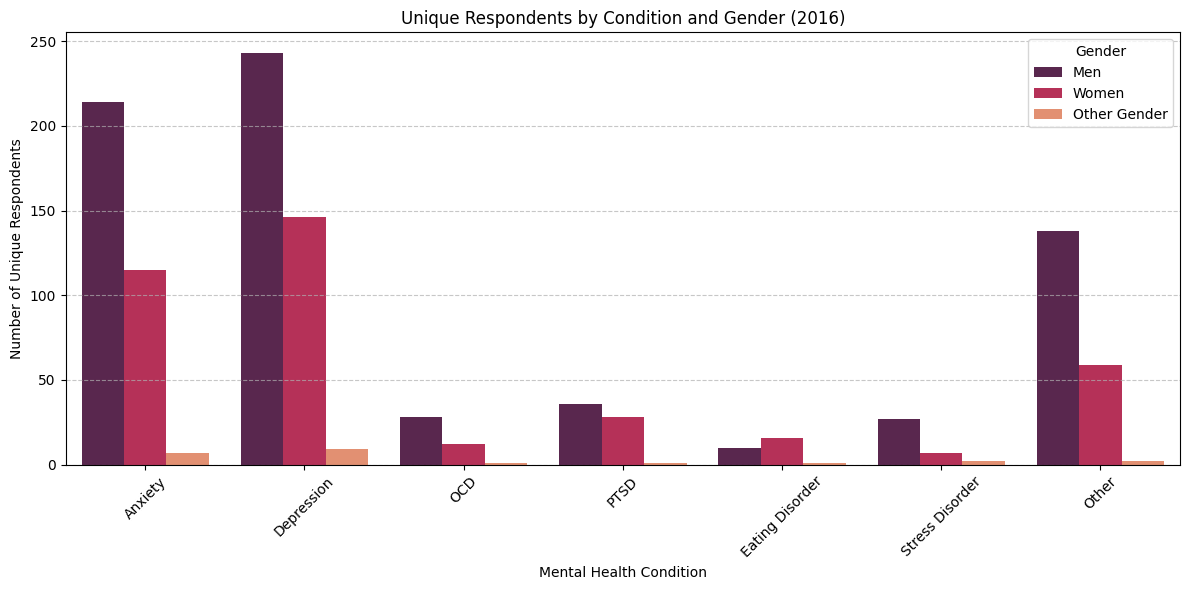

In [ ]:
men_conditions_2016 = count_men_conditions_2016(db_path, condition_mapping)
women_conditions_2016 = count_women_conditions_2016(db_path, condition_mapping)
other_gender_conditions_2016 = count_other_gender_conditions_2016(
    db_path, condition_mapping
)

plot_multibar_conditions_2016(
    men_conditions_2016, women_conditions_2016, other_gender_conditions_2016
)

The results indicates that men suffers from all mental conditions (except eating disorder), but we need to keep in mind that there most men respondants overall. We need to normalize results to see the clearer picture :

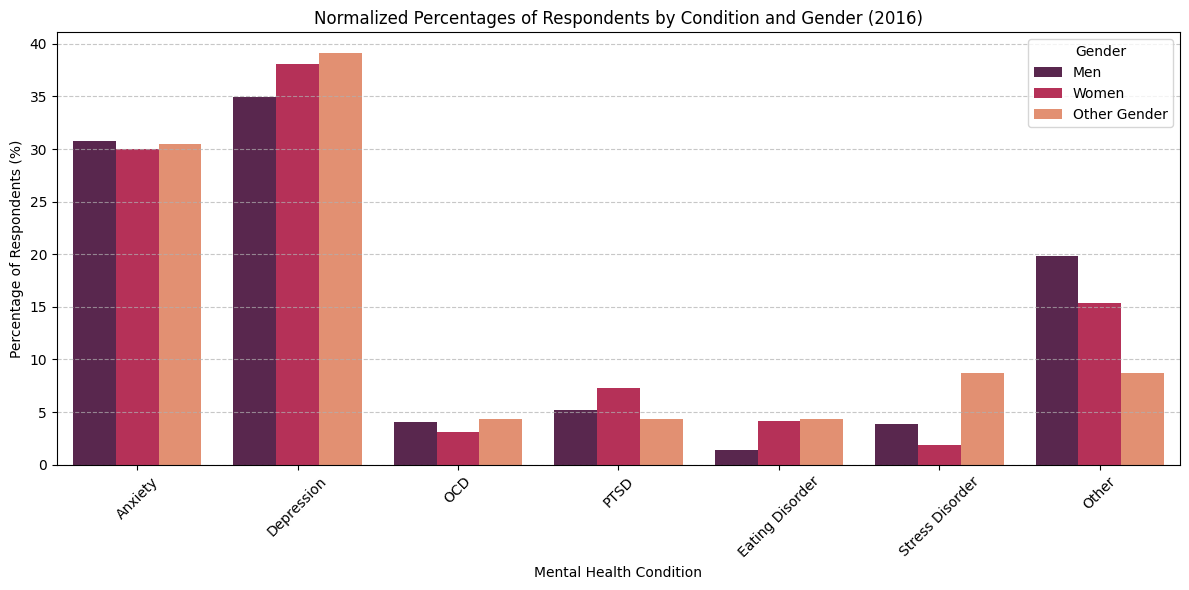


Normalized Percentages by Condition and Gender (2016):

Men:
  Anxiety: 30.75%
  Depression: 34.91%
  OCD: 4.02%
  PTSD: 5.17%
  Eating Disorder: 1.44%
  Stress Disorder: 3.88%
  Other: 19.83%

Women:
  Anxiety: 30.03%
  Depression: 38.12%
  OCD: 3.13%
  PTSD: 7.31%
  Eating Disorder: 4.18%
  Stress Disorder: 1.83%
  Other: 15.40%

Other Gender:
  Anxiety: 30.43%
  Depression: 39.13%
  OCD: 4.35%
  PTSD: 4.35%
  Eating Disorder: 4.35%
  Stress Disorder: 8.70%
  Other: 8.70%



In [42]:
plot_multibar_conditions_percentage_2016(
    men_conditions_2016, women_conditions_2016, other_gender_conditions_2016
)

Key Findings :

Women in the technology sector exhibit the highest percentage of PTSD among all groups. Additionally, they are significantly more likely than men to report Eating Disorders. Women are 1.6 times more likely to report an Eating Disorder compared to men, they also report PTSD 1.41 times more often than men

Men in the technology sector report the highest percentages of Depression and Anxiety. They also experience a highest share of Other mental health conditions, highlighting a broader range of challenges beyond the most commonly reported diagnoses. Men  are 1.29 times more likely to report "Other" mental health conditions compared to women (19.83% vs. 15.40%), and nearly 2.3 times more likely than Other Gender respondents (19.83% vs. 8.70%). These "Other" conditions often include less commonly reported or unspecified issues such as substance use disorders, sleep disorders, and mood disturbances not classified under Depression or Anxiety.

Respondents of Other gender (non- binary f.e.) show a more evenly distributed prevalence across mental health conditions. While Depression and Anxiety remain the most commonly reported, they also experience notably higher proportions of Stress Disorders and Eating Disorders compared to men and women. Almost 40% of Other gender respondants reported Depression which are the highest percentage of mental condition in any gender group.

Across all gender groups in the technology sector, Anxiety and Depression are the most commonly reported mental health conditions. 

## Analysis Conclusion

## Thoughts On How This Analysis Could Be Better